In [3]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl (2449.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp311-cp311-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/whl/filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached https://download.pytorch.org/whl/filelock-3.19.1-py3-none-any.whl (15 kB)
Using cached https://download.pytorch.org/whl

In [2]:
# ============================================================
#  IMPORT
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ============================================================
#  DATASET LOADER + AUGMENTATION
# ============================================================

img_size = 224
batch_size = 16

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder("data", transform=transform)

# Train / val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# ============================================================
#  RESNET BOTTLENECK BLOCK
# ============================================================

class ResNetBottleneck(nn.Module):
    def __init__(self, in_channels, filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, filters, 1)
        self.bn1 = nn.BatchNorm2d(filters)

        self.conv2 = nn.Conv2d(filters, filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters)

        self.conv3 = nn.Conv2d(filters, filters * 4, 1)
        self.bn3 = nn.BatchNorm2d(filters * 4)

        self.shortcut_needed = (in_channels != filters * 4)
        if self.shortcut_needed:
            self.shortcut_conv = nn.Conv2d(in_channels, filters * 4, 1)

    def forward(self, x):
        shortcut = x
        if self.shortcut_needed:
            shortcut = self.shortcut_conv(x)

        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        return torch.relu(x + shortcut)

# ============================================================
#  HYBRID MODEL: EfficientNetB0 + Bottleneck ResNet
# ============================================================

class HybridEfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # Load pretrained EfficientNet-B0
        self.base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Freeze feature extractor
        self.base.features.requires_grad_(False)

        in_channels = 1280  # output EfficientNetB0 channels

        self.b1 = ResNetBottleneck(in_channels, 64)
        self.b2 = ResNetBottleneck(64 * 4, 64)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64 * 4, num_classes)

    def forward(self, x):
        x = self.base.features(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [6]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = HybridEfficientNet(num_classes=4).to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using device: cuda


np.int64(1817068)

Using device: cuda
Epoch 1/50 | Train Loss: 0.6165 Acc: 0.7655 | Val Loss: 0.4952 Acc: 0.7956
Epoch 2/50 | Train Loss: 0.3299 Acc: 0.8873 | Val Loss: 0.3339 Acc: 0.8797
Epoch 3/50 | Train Loss: 0.2716 Acc: 0.9058 | Val Loss: 0.4643 Acc: 0.8233
Epoch 4/50 | Train Loss: 0.2521 Acc: 0.9079 | Val Loss: 0.2883 Acc: 0.9075
Epoch 5/50 | Train Loss: 0.2233 Acc: 0.9199 | Val Loss: 0.3475 Acc: 0.9029
Epoch 6/50 | Train Loss: 0.2178 Acc: 0.9257 | Val Loss: 0.2457 Acc: 0.9269
Epoch 7/50 | Train Loss: 0.2190 Acc: 0.9238 | Val Loss: 0.2528 Acc: 0.9084
Epoch 8/50 | Train Loss: 0.1838 Acc: 0.9347 | Val Loss: 0.2973 Acc: 0.8862
Epoch 9/50 | Train Loss: 0.1736 Acc: 0.9368 | Val Loss: 0.2659 Acc: 0.9038
Epoch 10/50 | Train Loss: 0.1799 Acc: 0.9387 | Val Loss: 0.2751 Acc: 0.8992
Epoch 11/50 | Train Loss: 0.1709 Acc: 0.9373 | Val Loss: 0.4648 Acc: 0.8390
Epoch 12/50 | Train Loss: 0.1546 Acc: 0.9481 | Val Loss: 0.2604 Acc: 0.9130
Epoch 13/50 | Train Loss: 0.1485 Acc: 0.9468 | Val Loss: 0.4035 Acc: 0.9306
Ep

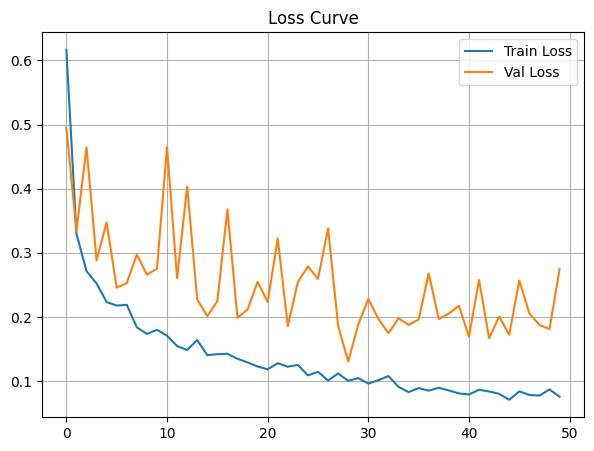

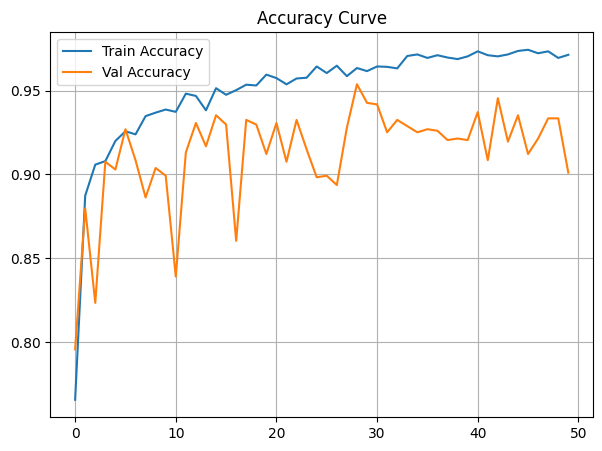

In [5]:


# ============================================================
#  TRAINING CONFIG
# ============================================================


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# ============================================================
#  TRAINING LOOP
# ============================================================

epochs = 50

for epoch in range(epochs):
    # -------- TRAINING --------
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total

    # -------- VALIDATION --------
    model.eval()
    val_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            v_correct += preds.eq(labels).sum().item()
            v_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = v_correct / v_total

    # Save metrics
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# ============================================================
#  SAVE MODEL
# ============================================================

torch.save(model.state_dict(), "hybrid_effnet_resnet.pth")
print("Model saved: hybrid_effnet_resnet.pth")

# ============================================================
#  SAVE HISTORY CSV
# ============================================================

pd.DataFrame(history).to_csv("training_history.csv", index=False)
print("Saved: training_history.csv")

# ============================================================
#  PLOT CURVES
# ============================================================

plt.figure(figsize=(7,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.grid()
plt.legend()
plt.show()